# Introduction to Telstra competition


This is the dataset that is used in the Telstra Network Disruptions competition that ran between Nov 2015 and Feb 2016
This competition provided a very nice and small dataset that allows many aspects of predictive modelling:

* relational data between different entities of the disruption data
* clean dataset that provides consistent and reliable feedback
* ideal for practices for many parts of the predictive modelling pipelin: feature engineering, cross-validation, stacking, etc
* Magic Feature! see forum thread for more details :)
* This dataset is re-uploaded since the original competition did not feature kernels, and it is made available here give people a chance to practice their data science/predictive modelling skill with this nice little dataset

# content




* The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files.

* Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many).

* Different types of features are extracted from log files and other sources: eventtype.csv, logfeature.csv, resourcetype.csv, severitytype.csv.

* Note: “severitytype” is a feature extracted from the log files (in severitytype.csv). Often this is a severity type of a warning message coming from the log. "severitytype" is categorical. It does not have an ordering. “faultseverity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

In [1]:
# Load the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

# Load the data

In [23]:
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
sample_submission = pd.read_csv('sample_submission.csv')
severity_type = pd.read_csv('severity_type.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [110]:
event_type.head()

,id,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,...,event_type_45,event_type_46,event_type_47,event_type_48,event_type_49,event_type_50,event_type_51,event_type_52,event_type_53,event_type_54
0,6597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [8]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [21]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


In [10]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


# 1. Lets do Exploratory data analysis ( EDA )

## analyse Train set

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.1+ KB


In [41]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [42]:
len(train.index)

7381

In [45]:
len(train.id.unique())

7381

In [46]:
len(train.location.unique())

929

In [47]:
len(train.fault_severity.unique())

3

In [51]:
train.isnull().sum()

id                0
location          0
fault_severity    0
dtype: int64

## Analysis Test set

In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11171 non-null  int64 
 1   location  11171 non-null  object
dtypes: int64(1), object(1)
memory usage: 174.7+ KB


In [56]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [57]:
len(test.index)

11171

In [54]:
len(test.id.unique())

11171

In [55]:
len(test.location.unique())

1039

In [59]:
test.isnull().sum()

id          0
location    0
dtype: int64

# combining training and test data into a single data set

In [65]:
# creating a colum of istrain in both train and test data

train['istrain'] = 1
test['istrain'] = 0

data = train.append(test)

# analysis data

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18552 non-null  int64  
 1   location        18552 non-null  object 
 2   fault_severity  7381 non-null   float64
 3   istrain         18552 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 724.7+ KB


In [66]:
data.head()

,id,location,fault_severity,istrain
0,14121,location 118,1.0,1
1,9320,location 91,0.0,1
2,14394,location 152,1.0,1
3,8218,location 931,1.0,1
4,14804,location 120,0.0,1


In [67]:
print('total number of rows in data: ' , len(data.index))
print('number of unique id :' , len(data.id.unique()))
print('number of unique locations:' , len(data.location.unique()))
print('number of unique fault severity:' , len(data.fault_severity.unique()))

total number of rows in data:  18552
number of unique id : 18552
number of unique locations: 1126
number of unique fault severity: 4


In [68]:
data.isnull().sum()

id                    0
location              0
fault_severity    11171
istrain               0
dtype: int64

# cleaning the data

In [69]:
# we will strip the location attribute and maintain the interger value of location

data.location = data.location.str.lstrip('location').astype('int')
data.head()

,id,location,fault_severity,istrain
0,14121,118,1.0,1
1,9320,91,0.0,1
2,14394,152,1.0,1
3,8218,931,1.0,1
4,14804,120,0.0,1


# visualizing the data

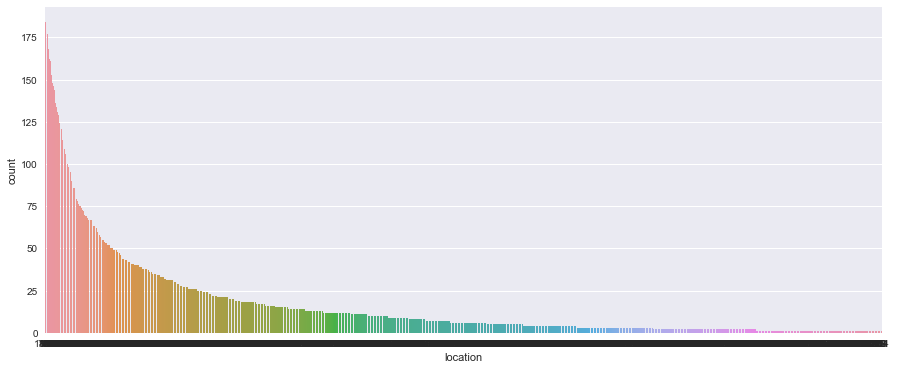

In [74]:
plt.figure(figsize=(15,6))
col = 'location'
sns.countplot(x = col , data = data , order=data[col].value_counts().index)

Text(0, 0.5, 'frequency')

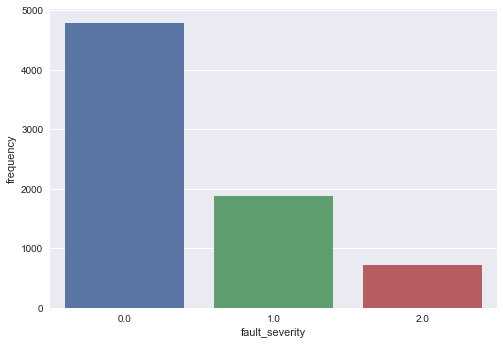

In [76]:
sns.countplot(x = 'fault_severity' , data = data)
plt.ylabel('frequency')

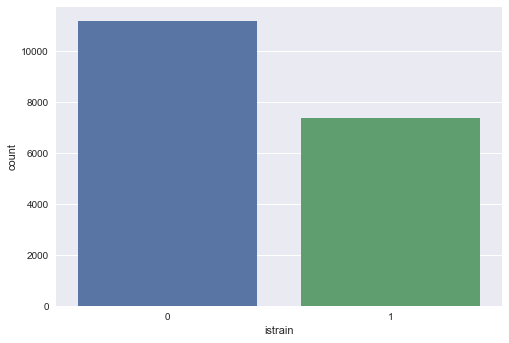

In [77]:
sns.countplot(x = 'istrain' , data = data)

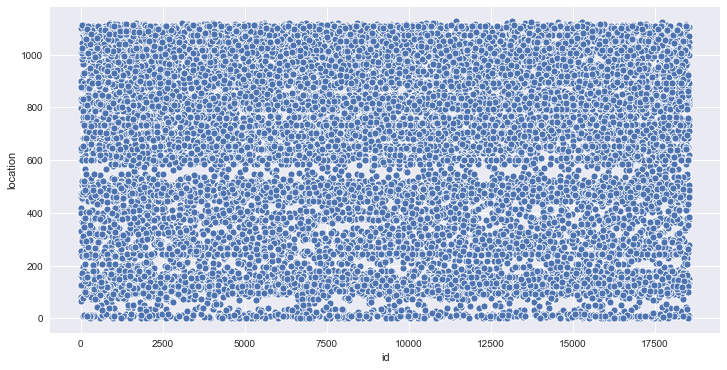

In [82]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'id' , y='location' , data= data  , cmap = 'virdis')

# Analysis event type

In [83]:
event_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31170 non-null  int64 
 1   event_type  31170 non-null  object
dtypes: int64(1), object(1)
memory usage: 487.2+ KB


In [84]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [85]:
len(event_type.index)

31170

In [86]:
len(event_type.id.unique())

18552

In [87]:
len(event_type.event_type.unique())

53

In [88]:
event_type.isnull().sum()

id            0
event_type    0
dtype: int64

# cleaning event type

In [89]:
event_type.event_type = event_type.event_type.str.lstrip('event_type').astype('int')
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


In [92]:
# one hot encoding using pandas

event_type = pd.get_dummies(event_type)
event_type.head()

,id,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,...,event_type_45,event_type_46,event_type_47,event_type_48,event_type_49,event_type_50,event_type_51,event_type_52,event_type_53,event_type_54
0,6597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# analysis Log features

In [93]:
log_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           58671 non-null  int64 
 1   log_feature  58671 non-null  object
 2   volume       58671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [94]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [104]:
print('total number of rows : ' , len(log_feature.index))
print('number of unique ids :' , len(log_feature.id.unique()))
print('number of unique log features:' , len(log_feature.log_feature.unique()))
print('number of unique volumes :' , len(log_feature.volume.unique()))


total number of rows :  58671
number of unique ids : 18552
number of unique log features: 386
number of unique volumes : 341


In [105]:
log_feature.isnull().sum()

id             0
log_feature    0
volume         0
dtype: int64

# cleaning log features

In [106]:
log_feature['log_feature'] = log_feature['log_feature'].str.lstrip('feature').astype('int')
log_feature.head()

,id,log_feature,volume
0,6597,68,6
1,8011,68,7
2,2597,68,1
3,5022,172,2
4,5022,56,1


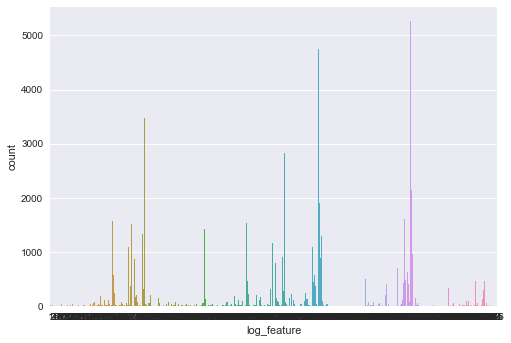

In [108]:
sns.countplot(x = 'log_feature' , data = log_feature)

# Analysis resourse type

In [111]:
resource_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             21076 non-null  int64 
 1   resource_type  21076 non-null  object
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [112]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [113]:
# clean the data of resourse type

resource_type['resource_type'] = resource_type['resource_type'].str.lstrip('resource_type').astype('int')
resource_type.head()

,id,resource_type
0,6597,8
1,8011,8
2,2597,8
3,5022,8
4,6852,8


In [114]:
resource_type['resource_type'].value_counts()

8     10268
2      8918
6       582
7       498
4       330
9       190
3       145
10       73
1        58
5        14
Name: resource_type, dtype: int64

In [116]:
resource_type = pd.get_dummies(resource_type , columns=['resource_type'])
resource_type.head()

,id,resource_type_1,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9,resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


# Analysis severity type

In [117]:
severity_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             18552 non-null  int64 
 1   severity_type  18552 non-null  object
dtypes: int64(1), object(1)
memory usage: 290.0+ KB


In [118]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [119]:
# cleaning the severity data

severity_type['severity_type'] = severity_type['severity_type'].str.lstrip('severity_type').astypeype('int')
severity_type.head()

,id,severity_type
0,6597,2
1,8011,2
2,2597,2
3,5022,1
4,6852,1


In [120]:
severity_type['severity_type'].value_counts()

2    8737
1    8728
4    1014
5      65
3       8
Name: severity_type, dtype: int64

In [121]:
# one hot encoding
severity_type = pd.get_dummies(severity_type , columns=['severity_type'])
severity_type.head()

,id,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5
0,6597,0,1,0,0,0
1,8011,0,1,0,0,0
2,2597,0,1,0,0,0
3,5022,1,0,0,0,0
4,6852,1,0,0,0,0


# analysis submission data

In [123]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         11171 non-null  int64
 1   predict_0  11171 non-null  int64
 2   predict_1  11171 non-null  int64
 3   predict_2  11171 non-null  int64
dtypes: int64(4)
memory usage: 349.2 KB


In [124]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


# **Feature Emgineering**

In [125]:
event_type = event_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

event_type.head()

,id,sum_event_type_1,sum_event_type_2,sum_event_type_3,sum_event_type_4,sum_event_type_5,sum_event_type_6,sum_event_type_7,sum_event_type_8,sum_event_type_9,...,sum_event_type_45,sum_event_type_46,sum_event_type_47,sum_event_type_48,sum_event_type_49,sum_event_type_50,sum_event_type_51,sum_event_type_52,sum_event_type_53,sum_event_type_54
0,6597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6852,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
log_feature = log_feature.groupby('id', sort=False).agg(count_log_feature=('log_feature','count'), 
                                                        sum_volume=('volume', 'sum'),
                                                        mean_volume=('volume', 'mean')
                                                      ).reset_index()
log_feature.head()

,id,count_log_feature,sum_volume,mean_volume
0,6597,1,6,6.000000
1,8011,1,7,7.000000
2,2597,1,1,1.000000
3,5022,4,10,2.500000
4,6852,3,5,1.666667


In [127]:
resource_type = resource_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

resource_type.head()

,id,sum_resource_type_1,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


In [153]:
dfs = [data, log_feature, severity_type, resource_type, event_type] 
df1 = pd.merge(data , log_feature)
df2 = pd.merge(df1 , severity_type)
df3 = pd.merge(df2 , resource_type)
result = pd.merge(df3 , event_type)

result.shape

(18552, 75)

In [143]:
data.shape , log_feature.shape , severity_type.shape , resource_type.shape , event_type.shape

((18552, 4), (18552, 4), (18552, 6), (18552, 11), (18552, 54))

In [154]:
result.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_event_type_45,sum_event_type_46,sum_event_type_47,sum_event_type_48,sum_event_type_49,sum_event_type_50,sum_event_type_51,sum_event_type_52,sum_event_type_53,sum_event_type_54
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
result.isnull().sum()

id                       0
location                 0
fault_severity       11171
istrain                  0
count_log_feature        0
                     ...  
sum_event_type_50        0
sum_event_type_51        0
sum_event_type_52        0
sum_event_type_53        0
sum_event_type_54        0
Length: 75, dtype: int64

# Now its time to split the train and test data set

In [159]:
train = result[result['istrain'] == 1]
train.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_event_type_45,sum_event_type_46,sum_event_type_47,sum_event_type_48,sum_event_type_49,sum_event_type_50,sum_event_type_51,sum_event_type_52,sum_event_type_53,sum_event_type_54
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
test = result[result['istrain'] == 0]
test.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_event_type_45,sum_event_type_46,sum_event_type_47,sum_event_type_48,sum_event_type_49,sum_event_type_50,sum_event_type_51,sum_event_type_52,sum_event_type_53,sum_event_type_54
7381,11066,481,NaN,0,4,98,24.5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7382,18000,962,NaN,0,2,29,14.5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7383,16964,491,NaN,0,2,21,10.5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7384,4795,532,NaN,0,3,3,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7385,3392,600,NaN,0,2,8,4.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Data Modelling

In [163]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

X = train.drop(columns='fault_severity')

# Prediction target - Training data
y = train['fault_severity']

# Selected features - Test data
x = test.drop(columns='fault_severity')

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Train Validation Split Complete")

Train Validation Split Complete


In [176]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()

dt_model.fit(X_train , y_train)
dtc = dt_model.score(X_valid , y_valid)*100
dtc

64.65809072444144

In [177]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()

rfc_model.fit(X_train , y_train)
rfc = rfc_model.score(X_valid , y_valid)*100
rfc

70.48070412999323

In [183]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

gnb_model.fit(X_train , y_train)
gnb = gnb_model.score(X_valid , y_valid)*100
gnb

51.99729180771835

In [184]:
from sklearn.naive_bayes import MultinomialNB

mnb_model = MultinomialNB()

mnb_model.fit(X_train , y_train)
mnb = mnb_model.score(X_valid , y_valid)*100
mnb

42.857142857142854

In [185]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train , y_train)
lr = lr_model.score(X_valid , y_valid)*100
lr

23.13854168656707

In [186]:
from sklearn.linear_model import LogisticRegression

logr_model = LogisticRegression()

logr_model.fit(X_train , y_train)
logr = logr_model.score(X_valid , y_valid)*100
logr

C:\Users\kunal.sharma2395\Desktop\sample_project\env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


63.100880162491535

In [187]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(X_train , y_train)
svc = svc_model.score(X_valid , y_valid)*100
svc

64.86120514556534

In [199]:
model_details = pd.DataFrame({'Decision Tree': dtc,
                             'Randomforest classifier': rfc,
                             'Gaussian NB': gnb,
                             'Multinomil NB': mnb,
                             'Linear regression' : lr,
                             'Logistic regression': logr,
                             'Support vector classifier': svc} , index = ['score'])

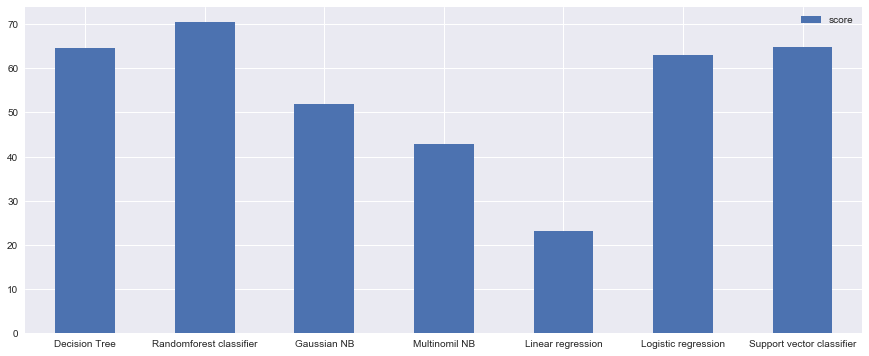

In [204]:

model_details.transpose().plot(kind= 'bar' , rot = 0 ,figsize=(15,6))

In [207]:
y_preds = rfc_model.predict(X_valid)

In [209]:
from sklearn.metrics import classification_report  , confusion_matrix

print(confusion_matrix(y_valid , y_preds))

[[793 129  36]
 [179 162  24]
 [ 40  28  86]]


In [210]:
print(classification_report(y_valid , y_preds))

              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81       958
         1.0       0.51      0.44      0.47       365
         2.0       0.59      0.56      0.57       154

    accuracy                           0.70      1477
   macro avg       0.63      0.61      0.62      1477
weighted avg       0.70      0.70      0.70      1477



# Thank You